## Reduced equations for linear bending waves

The name "reduced equations for linear bending waves" comes from Lubow+Ogilvie 2000; it refers to Eqs. 8-9 in Lubow+Ogilvie 2000. This pair of coupled PDEs relates the tilt $\mathcal{W}$ and the internal torque $\mathcal{G}$:

$$ \frac{\partial \mathcal{G}}{\partial t} = \frac{\Sigma H^2 \Omega^3 R^3}4 \frac{\partial \mathcal{W}}{\partial R}  - \left( \frac{\kappa^2 - \Omega^2}{\Omega^2} \right) \frac{i\Omega}2 \mathcal{G} - \alpha \Omega \mathcal{G}, $$
$$ \frac{\partial \mathcal{W}}{\partial t} = \frac{1}{\Sigma \Omega R^3 } \frac{\partial \mathcal{G}}{\partial R} - \left(\frac{\Omega_z^2 - \Omega^2}{\Omega^2} \right) \frac{i\Omega}2 \mathcal{W}.$$

## Imports and normalizations

In [1]:
# %pip install fipy

# make 3D plots interactive
# %matplotlib ipympl 
%matplotlib notebook

import numpy as np
import time
import math
#import scipy.differentiate
import scipy.integrate as integ
import scipy.interpolate as interp

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
cs = 0.02
alpha = 0.01 # 0.1 # 0.019

## Numerical derivatives

In [3]:
def derivative(f, x):
    '''
    Returns first derivative of f(x) with respect to the domain x.

    '''
    
    # return scipy.differentiate.derivative(f, x)

    derivs = np.zeros(shape=f.shape)

    # handle boundaries
    derivs[0] = (f[1] - f[0]) / (x[1] - x[0])
    derivs[-1] = (f[-1] - f[-2]) / (x[-1] - x[-2])

    # central difference method
    for i in range(1, len(x)-1):
        derivs[i] = (f[i+1] - f[i-1]) / (x[i+1] - x[i-1])

    return derivs

## Disk information

Normalizations:
- $R_0 = 1$
- $\Omega_{K,0} = 1$ (so $GM = 1$)
- $\Sigma_0 = 1$
- $c_s = 0.02$
- $\alpha = 0.019$
- Density profile: $K, R_a, R_b, D_a, D_b = 19, 1, 2, 0.1, 0.2$

### Density profile

In [4]:
def Sigma(Rs):
    '''
    Returns the disk's background surface density profile.
    
    '''
    
    K, R_a, R_b, D_a, D_b = 19, 1, 2, 0.1, 0.2
    fgaps = f_gap(Rs, K, R_a, R_b, D_a, D_b)
    
    Sigma0 = 1
    
    return Sigma0 * Rs**(-3/2) / fgaps

def f_gap(Rs, K, R_a, R_b, D_a, D_b):
    '''
    Function that "shapes" the disk gap profile. Used in `sigma` function. 
    R_a and R_b are the locations of the inner and outer gap edges,
    D_a and D_b are the steepness of the edges, and K determines the
    depth of the gap.
    
    '''

    return 1 + (K-1)/2 * \
        (np.tanh((Rs - R_a)/D_a) - np.tanh((Rs - R_b)/D_b))

In [5]:
## check shape of disk profile
#K, R_a, R_b, D_a, D_b = 19, 1, 2, 0.1, 0.2
#plt.plot(Rs_warp, Sigma(Rs_warp))

### Keplerian orbital frequency

Scale height, which depends on $\Omega$, is defined in the "Planet information" section below.

In [6]:
def OmegaK(Rs):
    '''
    Returns the Keplerian orbital frequency profile.
    Omega_K = sqrt(G*M_star / R^3)

    '''
    OmegaK_0 = 1 # Omega_K at R=R_0
    return OmegaK_0 * Rs**(-3/2)

## Planet information

If we insert one planet at the disk's inner boundary and one at the disk's outer boundary, can we reproduce Jiaru's results from using fixed (i.e., Dirichlet) boundary conditions?

### Laplace coefficients

In [7]:
def laplace_coeff_integrand(phi, x, j, s):
    '''
    
    This function represents the integrand of the Laplace coefficient formula
    (Eq. 6.67 of Murray & Dermott). The result is used in the laplace_coeff function.
    
    PARAMETERS
    ----------
    phi: the variable that we integrate over
    x: the variable that isn't integrated over
    j, s: See Eq. 6.67 of Murray & Dermott or Eq. 21 in Lubow+Ogilvie.
    
    '''
    
    num = np.cos(j*phi) # numerator
    denom = (1 - 2 * x * np.cos(phi) + x**2) ** s
    
    return num / denom

def laplace_coeff(x, j, s):
    '''
    
    Calculate the Laplace coefficient using Eq. 6.67 of Murray & Dermott.

    
    PARAMETERS
    ----------
    x: argument of the Laplace coefficient formula
    
    '''
    
    return 2 / np.pi * integ.quad(laplace_coeff_integrand, 0, np.pi, args=(x, j, s))[0]

Depending on whether the planet is inside ($R \gg a$; large $\alpha$) or outside ($R \ll a$; small $\alpha$) the disk, we have to interpolate the Laplace coefficients differently:

In [8]:
use_large_alpha = False

# interpolate Laplace coefficient function (~10x faster)
if use_large_alpha:
    xs_temp = np.linspace(1.1, 100, 1000)
    ys_temp = [laplace_coeff(x, j=0, s=3/2) for x in xs_temp]
    b0_interp = interp.CubicSpline(xs_temp, ys_temp)

    xs_temp = np.linspace(1.1, 100, 1000)
    ys_temp = [laplace_coeff(x, j=1, s=3/2) for x in xs_temp]
    b1_interp = interp.CubicSpline(xs_temp, ys_temp)
else:
    xs_temp = np.linspace(1e-6, .99, 1000)
    ys_temp = [laplace_coeff(x, j=0, s=3/2) for x in xs_temp]
    b0_interp = interp.CubicSpline(xs_temp, ys_temp)

    xs_temp = np.linspace(1e-6, .99, 1000)
    ys_temp = [laplace_coeff(x, j=1, s=3/2) for x in xs_temp]
    b1_interp = interp.CubicSpline(xs_temp, ys_temp)

In the limit of small or large $\alpha \equiv R/a$, we can also just use the quadropole limit of the Laplace coefficients:



In [9]:
def b0_approx(alpha, limit):
    '''
    Approximates the Laplace coefficient b^0_{3/2} as a function of 
    alpha = R/a.
    
    If alpha << 1, set `limit` to "small". If alpha >> 1, set 
    `limit` to "large".
    
    '''
    
    if limit=="small":
        return 2 
    elif limit=="large":
        return 2/alpha**3
    else:
        raise ValueError("limit must be either \"small\" or \"large.\"")

def b1_approx(alpha, limit):
    '''
    Approximates the Laplace coefficient b^1_{3/2} as a function of 
    alpha = R/a.
    
    '''
    
    if limit=="small":
        return 3*alpha 
    elif limit=="large":
        return 3/alpha**4 
    else:
        raise ValueError("limit must be either \"small\" or \"large.\"")

Finally, let's check that our interpolated and approximated functions are accurate:

In [10]:
if use_large_alpha:
    print("Correctness check: for alpha >> 1, b^1_{3/2} ~ 3/alpha^4.")
    x = 10
    print(laplace_coeff(x, j=1, s=3/2))
    print(b1_interp(x))
    print(b1_approx(x,limit="large"))

    print("\nCorrectness check: for alpha >> 1, b^0_{3/2} ~ 2/alpha^3.")
    x = 10
    print(laplace_coeff(x, j=0, s=3/2))
    print(b0_interp(x))
    print(b0_approx(x,limit="large"))
else:
    print("\nCorrectness check: for alpha << 1, b^1_{3/2} ~ 3*alpha.")
    x = .003
    print(laplace_coeff(x, j=1, s=3/2))
    print(b1_interp(x))
    print(b1_approx(x,limit="small"))

    print("\nCorrectness check: for alpha << 1, b^0_{3/2} ~ 2.")
    x = .0001
    print(laplace_coeff(x, j=0, s=3/2))
    print(b0_approx(x,limit="small"))



Correctness check: for alpha << 1, b^1_{3/2} ~ 3*alpha.
0.009000151876993288
0.009000151876993098
0.009000000000000001

Correctness check: for alpha << 1, b^0_{3/2} ~ 2.
2.000000045000001
2


### Orbital, epicyclic, and radial frequencies

(I use Eqs. 25-27 in Lubow+Ogilvie 2000.)

In [11]:
def Omega(Rs, Mp, a):
    '''
    Returns the disk's orbital frequency profile. 
    
    VARIABLES:
    ----------
    Rs is the radial domain.
    Mp is the ratio of the planet's mass to the star mass (using the normalization 
    GM_star = 1). For example, if we assume M_star = 1 M_sun, then a Jupiter-mass
    planet would have Mp = 0.1.
    a is the radius of the planet's orbit.

    '''

    OmegaKs = OmegaK(Rs)
    alphas = Rs/a
    
    if (alphas[0] < 1): # outer planet limit
        term2 = Mp/(2 * a**2 * Rs) * (alphas*b0_approx(alphas, "small") - \
                                      b1_approx(alphas, "small"))
    else: # inner planet limit
        term2 = Mp/(2 * a**2 * Rs) * (alphas*b0_approx(alphas, "large") - \
                                      b1_approx(alphas, "large"))
    Omegas_sq = OmegaKs**2 + term2
    
    return np.sqrt(Omegas_sq)

def Kappa(Rs, Mp, a):
    '''
    Returns the disk's epicyclic frequency profile. 
    
    VARIABLES:
    ----------
    Rs is the radial domain.
    Mp is the ratio of the planet's mass to the star mass (using the normalization 
    GM_star = 1). For example, if we assume M_star = 1 M_sun, then a Jupiter-mass
    planet would have Mp = 0.1.
    a is the radius of the planet's orbit.

    '''

    OmegaKs = OmegaK(Rs)
    alphas = Rs/a
        
    if (alphas[0] < 1): # outer planet limit
        term2 = Mp/(2 * a**2 * Rs) * (alphas*b0_approx(alphas, "small") - \
                                      2*b1_approx(alphas, "small"))
    else: # inner planet limit
        term2 = Mp/(2 * a**2 * Rs) * (alphas*b0_approx(alphas, "large") - \
                                      2*b1_approx(alphas, "large"))
    kappas_sq = OmegaKs**2 + term2
    
    return np.sqrt(kappas_sq)

def Omega_z(Rs, Mp, a):
    '''
    Returns the disk's vertical frequency profile. 
    
    VARIABLES:
    ----------
    Rs is the radial domain.
    Mp is the ratio of the planet's mass to the star mass (using the normalization 
    GM_star = 1). For example, if we assume M_star = 1 M_sun, then a Jupiter-mass
    planet would have Mp = 0.1.
    a is the radius of the planet's orbit.

    '''

    OmegaKs = OmegaK(Rs)
    alphas = Rs/a
    
    if (alphas[0] < 1): # outer planet limit
        term2 = Mp/(2 * a**2 * Rs) * alphas*b0_approx(alphas, "small")
    else: # inner planet limit
        term2 = Mp/(2 * a**2 * Rs) * alphas*b0_approx(alphas, "large")
    Omegazs_sq = OmegaKs**2 + term2
    
    return np.sqrt(Omegazs_sq)

### Disk scale height

In [12]:
def scaleHeight(Rs, Mp, a):
    '''
    Returns the disk's scale height profile. We use H = c_sound / Omega.

    '''
    return cs / Omega(Rs, Mp, a)

## Integration functions

Boundary conditions:
- $\frac{\partial \mathcal{W}}{\partial R} (R_\text{min}, t) = 0$
- $\frac{\partial \mathcal{W}}{\partial R} (R_\text{max}, t) = 0$

Initial conditions:
- $\mathcal{W}(R_\text{min}, 0) = 0$ 
- $\mathcal{W}(R_\text{max}, 0) = 0.1$ 
- $\mathcal{W}(R,0)$ is some smooth function (eg, Gaussian integral)

In [58]:
def dG_dt(Rs_torque, Gs, Rs_warp, Ws, Mp, a, use_ext_torque):
    '''
    Returns dG/dt over the R domain (Rs_torque) for Gs.
    
    Assumes that `Ws` and `Gs` are staggered in the R domain:
    Ws should be indexed from 0 through N, while `Gs` should be indexed
    from 1/2 to N-1/2.
    
    Mp and a are the planet's mass and orbital radius respectively.
    
    We include an external torque (i.e., a planet) iff ``use_ext_torque'' is True.

    '''

    # since we're changing G, compute values over G's R domain
    Sigmas = Sigma(Rs_torque) # length N
    Hs = scaleHeight(Rs_torque, Mp, a)
    Omegas = Omega(Rs_torque, Mp, a)
    
    dW_dRs = (Ws[1:] - Ws[:-1]) / (Rs_warp[1:] - Rs_warp[:-1]) # length N

    # sloshing term
    slosh_term = Sigmas * (Hs**2) * (Omegas**3) * (Rs_torque**3) / 4 * dW_dRs
    # external torque term
    ext_term = 0 
    if use_ext_torque:
        Kappas = Kappa(Rs_torque, Mp, a)
        ext_term = (-1) * (Kappas**2 - Omegas**2) / (Omegas**2) * (1j*Omegas/2) * Gs
    # viscous term
    visc_term = (-1) * alpha * Omegas * Gs 
    
    dG_dts = slosh_term + ext_term + visc_term
    
    return dG_dts

def dW_dt(Rs_torque, Gs, Rs_warp, Ws, Mp, a, use_ext_torque,\
          inner_Neumann, outer_Neumann):
    '''
    Returns dW/dt over the R domain (Rs) for Ws.
    
    Assumes that `Ws` and `Gs` are staggered in the R domain:
    Ws should be indexed from 0 through N, while `Gs` should be indexed
    from 1/2 to N-1/2.
    
    Mp and a are the planet's mass and orbital radius respectively.
    
    We include an external torque (i.e., a planet) iff ``use_ext_torque'' is True.
    
    If `inner_Neumann` is True, ensures that dW_dR=0 at the inner boundary 
    (ie, at R_min). Else, we do not change W at R_min (this is equivalent to 
    a Dirichlet boundary condition).
    The same is true for `outer_Neumann`, except applied to the outer boundary.

    '''

    # since we're changing W, compute values over W's R domain
    Sigmas = Sigma(Rs_warp) # length N+1
    Omegas = Omega(Rs_warp, Mp, a)
    
    # defines dG_dR for indices 1 through N-1
    dG_dRs_middle = (Gs[1:] - Gs[:-1]) / (Rs_torque[1:] - Rs_torque[:-1]) # length N-1
    dG_dRs = np.zeros(shape=Rs_warp.shape, dtype=complex)
    dG_dRs[1:-1] = dG_dRs_middle
    
    # torquing term
    torq_term = dG_dRs / (Sigmas * Omegas * Rs_warp**3)
    ext_term = 0
    if use_ext_torque:
        Omega_zs = Omega_z(Rs_warp, Mp, a)
        ext_term = (-1) * (Omega_zs**2 - Omegas**2) / (Omegas**2) * (1j*Omegas/2) * Ws

    dW_dts = torq_term + ext_term
    
    # enforce boundary conditions
    if inner_Neumann: # dW/dR = 0
        dW_dts[0] = dW_dts[1]
    else: # W fixed (Dirichlet BC)
        dW_dts[0] = 0
        
    if outer_Neumann:
        dW_dts[-1] = dW_dts[-2]
    else:
        dW_dts[-1] = 0
    
    return dW_dts

In [14]:
def evolve_G(Rs_torque, Gs, Rs_warp, Ws, dt, Mp, a, use_ext_torque):
    '''
    Use the predictor-corrector method to evolve G(R) forward by one timestep (dt).
    W and G are staggered in the R domain.
    
    Mp and a are the planet's mass and orbital radius respectively.
        
    We include an external torque (i.e., a planet) iff ``use_ext_torque'' is True.

    '''

    # predictor step
    F1 = dG_dt(Rs_torque, Gs, Rs_warp, Ws, Mp, a, use_ext_torque)
    Gprimes = Gs + F1*dt

    # corrector step
    F2 = dG_dt(Rs_torque, Gprimes, Rs_warp, Ws, Mp, a, use_ext_torque)
    Gnexts = Gs + (F1+F2)/2 * dt

    return Gnexts

def evolve_W(Rs_torque, Gs, Rs_warp, Ws, dt, Mp, a, use_ext_torque, \
             inner_Neumann, outer_Neumann):
    '''
    Use the predictor-corrector method to evolve W(R) forward by one timestep (dt).
    W and G are staggered in the R domain.
    
    Mp and a are the planet's mass and orbital radius respectively.
    
    We include an external torque (i.e., a planet) iff ``use_ext_torque'' is True.
    
    If `inner_Neumann` is True, ensures that dW_dR=0 at the inner boundary 
    (ie, at R_min). Else, we do not change W at R_min (this is equivalent to 
    a Dirichlet boundary condition).
    The same is true for `outer_Neumann`, except applied to the outer boundary.
    See `dW_dt` function.
    
    '''

    # predictor step
    F1 = dW_dt(Rs_torque, Gs, Rs_warp, Ws, Mp, a, use_ext_torque, \
             inner_Neumann, outer_Neumann)
    Wprimes = Ws + F1*dt

    # corrector step
    F2 = dW_dt(Rs_torque, Gs, Rs_warp, Wprimes, Mp, a, use_ext_torque, \
             inner_Neumann, outer_Neumann)
    Wnexts = Ws + (F1+F2)/2 * dt

    return Wnexts

In [15]:
def integrate(Rs_torque, Gs, Rs_warp, Ws, ts, Mp, a, use_ext_torque=False,\
          inner_Neumann=False, outer_Neumann=False):
    '''

    Integrate W(R) and G(R) over a given time domain (ts). Returns W(R) and 
    G(R) at the final timestep.
    
    W and G are staggered in the R domain.
    
    Mp and a are the planet's mass and orbital radius respectively.
    
    We include an external torque (i.e., a planet) iff ``use_ext_torque'' is True.
    
    If `inner_Neumann` is True, ensures that dW_dR=0 at the inner boundary 
    (ie, at R_min). Else, we do not change W at R_min (this is equivalent to 
    a Dirichlet boundary condition).
    The same is true for `outer_Neumann`, except applied to the outer boundary.
    See `dW_dt` function.

    '''

    for i in range(len(ts)-1):
        t = ts[i]
        dt = ts[i+1] - ts[i]
        Gnexts = evolve_G(Rs_torque, Gs, Rs_warp, Ws, dt, Mp, a, use_ext_torque)
        Wnexts = evolve_W(Rs_torque, Gs, Rs_warp, Ws, dt, Mp, a, use_ext_torque, \
             inner_Neumann, outer_Neumann)

        Ws, Gs = Wnexts, Gnexts 

    return Ws, Gs

## Run a sim (1 inner planet)

Note that, from the $\frac{\partial \mathcal{G}}{\partial t} = \frac{\Sigma H^2 \Omega^3 R^3}4 \frac{\partial \mathcal{W}}{\partial R}  - \alpha \Omega G$, we can see that $t \sim \Omega^{-1} h^{-1}$ and $t \sim \Omega^{-1} \alpha^{-1} $ are both relevant timescales. This corresponds to $\sim$10-100 $\Omega^{-1}$.

In [67]:
# spatial and time domains
Rmin = 0.5
Rmax = 3.5
DeltaR = 0.1
num_Rs = (int) ((Rmax - Rmin) / DeltaR) + 1

# stagger W and G in the R domain
Rs_warp = np.linspace(Rmin, Rmax, num_Rs)
Rs_torque = Rs_warp[:-1] + DeltaR/2

tmin = 0
tmax = 1000
Deltat = 0.03
num_ts = (int) ((tmax - tmin) / Deltat) + 1
ts = np.linspace(tmin, tmax, num_ts)

Ws_init = 0.1 * np.cumsum(np.exp(-(Rs_warp-2)**2 / 2) / np.sqrt(2*np.pi)) * DeltaR
#Ws_init = (Ws_init + 0.5j*Ws_init).astype(complex)
Ws_init -= Ws_init[-1] # sets inclination=0 at outer edge
Ws_init.astype(complex)

#Ws = np.zeros(shape=Rs.shape) + (Rs-0.5)/30 # tilt W(R)
Gs_init = np.zeros(shape=Rs_torque.shape) # torque G(R)
Gs_init = Gs_init.astype(complex)

# Mp, a = 0.01, 0.45 # inner planet
Mp, a = 0.1, 4 # outer planet

In [68]:
use_innNeum = False
use_outNeum = True

start = time.time()
Ws_final, Gs_final = integrate(Rs_torque, Gs_init, Rs_warp, Ws_init, ts, Mp, a, \
                               use_ext_torque=True,\
                               inner_Neumann=use_innNeum,\
                              outer_Neumann=use_outNeum)
## use below line if you want to use a previous sim's results
# Ws_final, Gs_final = integrate(Rs_torque, Gs_final, Rs_warp, Ws_final, ts)
end = time.time()
print("Elapsed time:", np.round(end - start, 2))

Elapsed time: 5.25


<IPython.core.display.Javascript object>


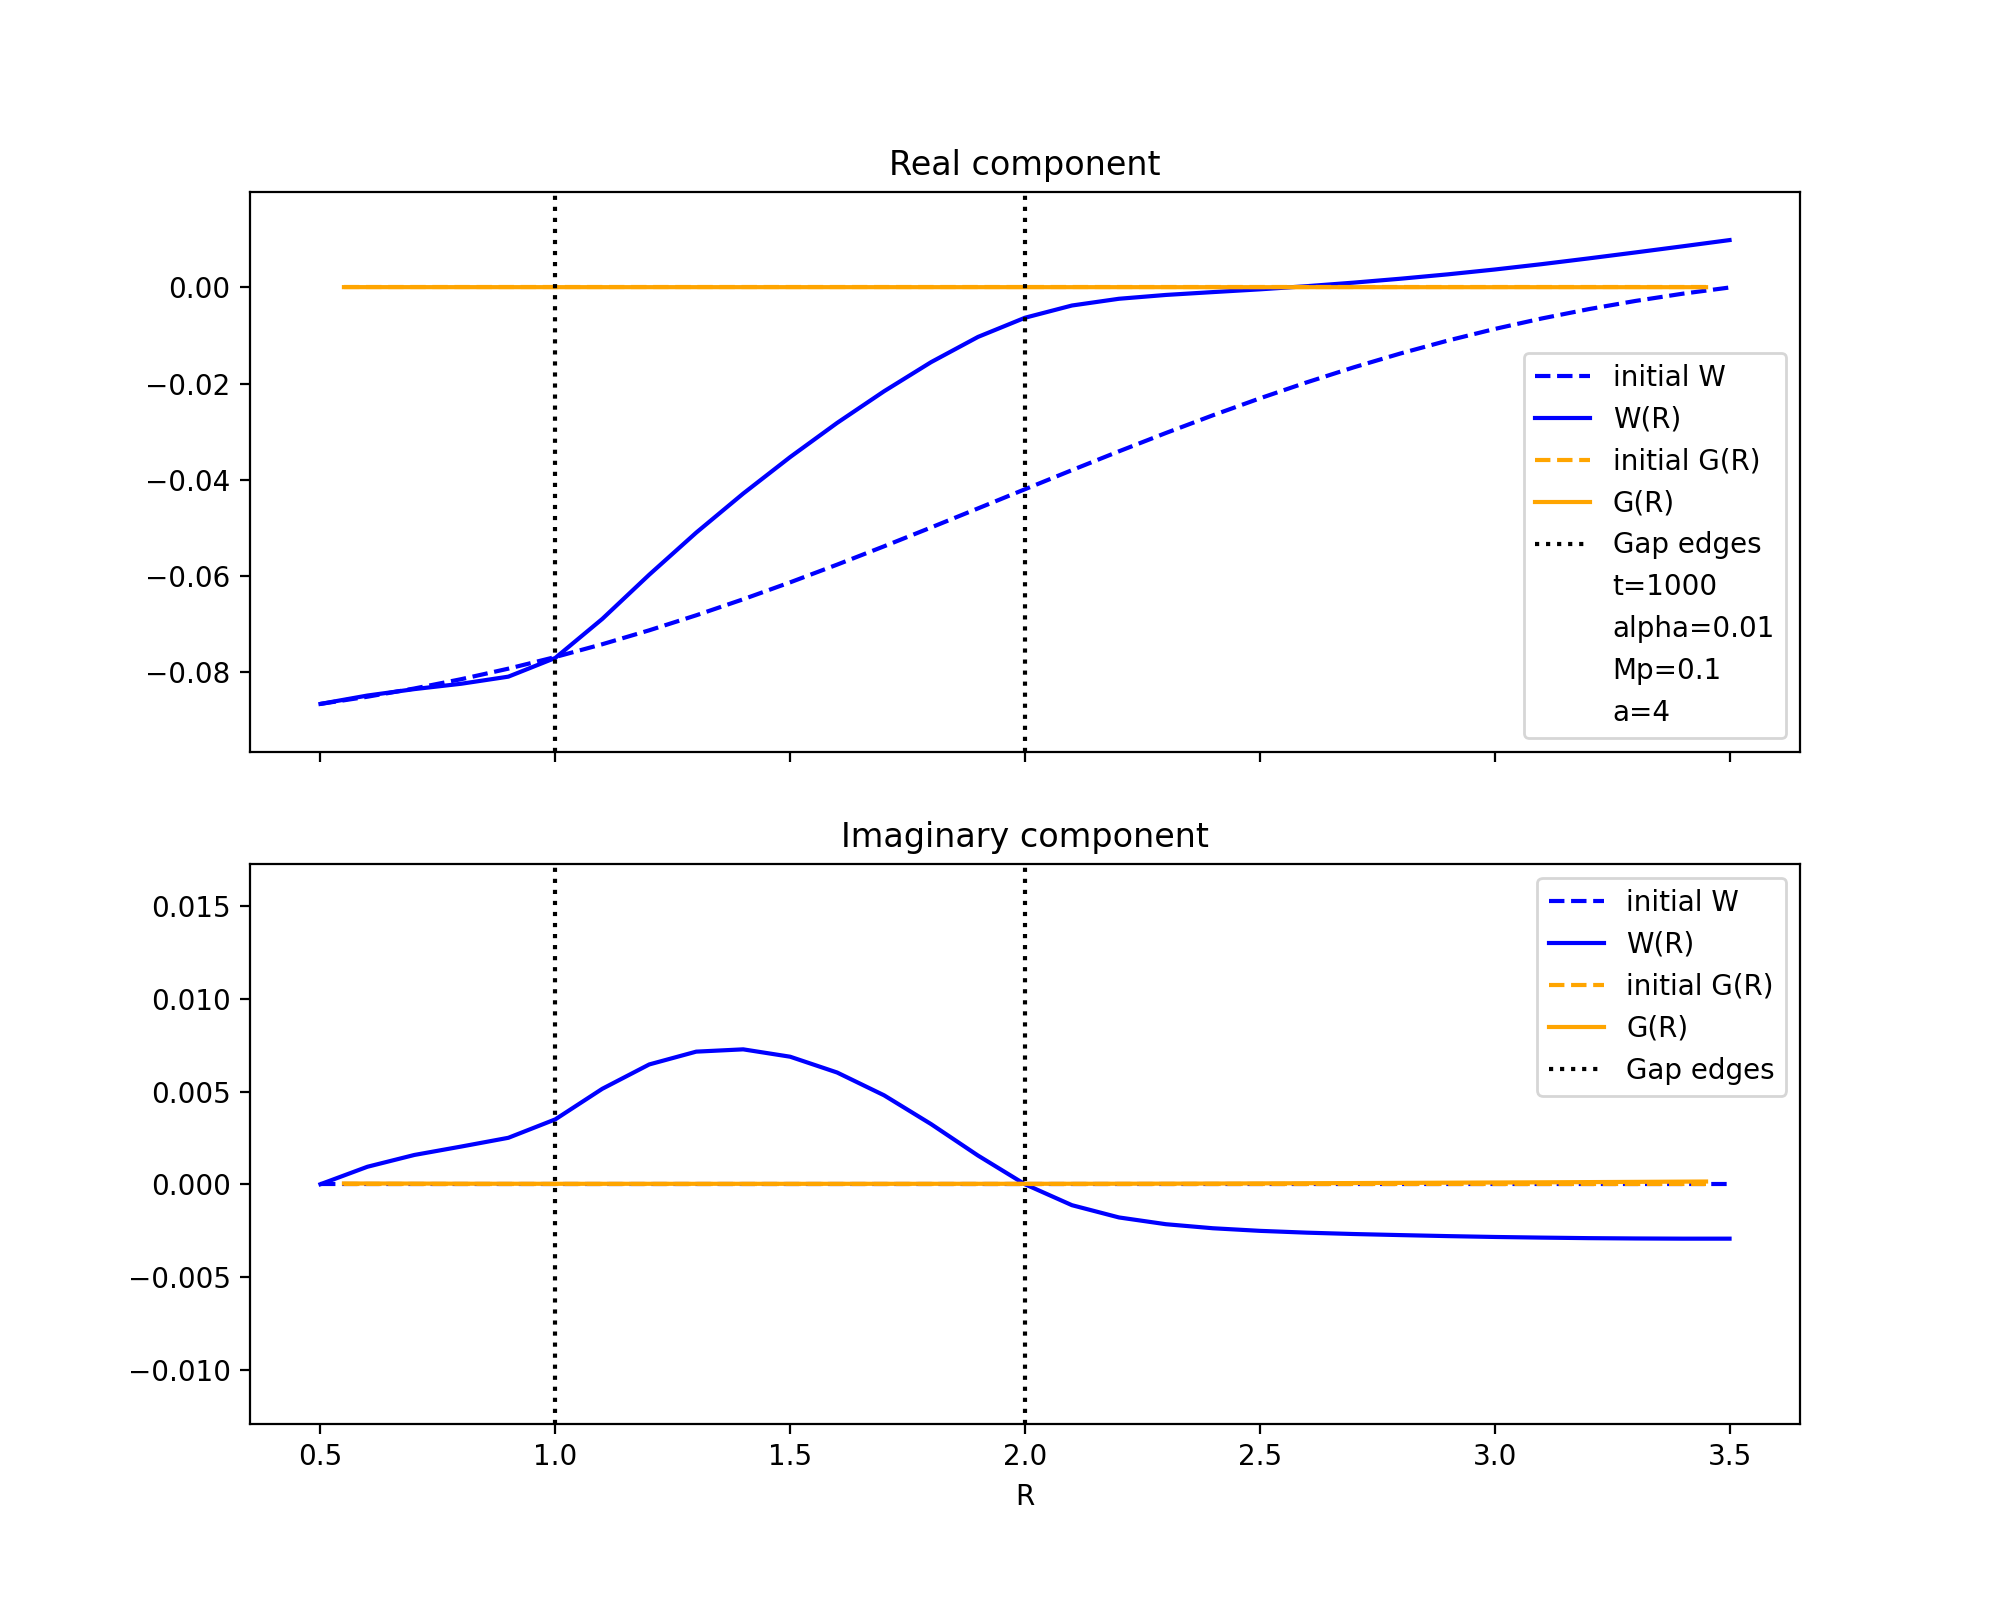

In [69]:
fig, axs = plt.subplots(2, sharex=True, figsize=(10,8))
fig.set_facecolor("white")

axs[0].plot(Rs_warp, Ws_init.real, c="blue", ls="--", label="initial W")
axs[0].plot(Rs_warp, Ws_final.real, c="blue", label="W(R)")
axs[0].plot(Rs_torque, Gs_init.real, c="orange", ls="--", label="initial G(R)")
axs[0].plot(Rs_torque, Gs_final.real, c="orange", label="G(R)")

ymin, ymax= min(0, min(Ws_final.real)) - .01, max(Ws_final.real) + .01
R_a, R_b = 1, 2
axs[0].vlines(R_a, ymin, ymax, color="black", linestyle=":")
axs[0].vlines(R_b, ymin, ymax, color="black", linestyle=":", label="Gap edges")

axs[0].set_ylim(ymin,ymax)

axs[0].scatter([],[], s=0, label="t=" + str(tmax))
axs[0].scatter([],[], s=0, label="alpha=" + str(alpha))
axs[0].scatter([],[], s=0, label="Mp=" + str(Mp))
axs[0].scatter([],[], s=0, label="a=" + str(a))

axs[0].legend()
axs[0].set_title("Real component")

axs[1].plot(Rs_warp, Ws_init.imag, c="blue", ls="--", label="initial W")
axs[1].plot(Rs_warp, Ws_final.imag, c="blue", label="W(R)")
axs[1].plot(Rs_torque, Gs_init.imag, c="orange", ls="--", label="initial G(R)")
axs[1].plot(Rs_torque, Gs_final.imag, c="orange", label="G(R)")

ymin, ymax= min(Ws_final.imag) - .01, max(Ws_final.imag) + .01
R_a, R_b = 1, 2
axs[1].vlines(R_a, ymin, ymax, color="black", linestyle=":")
axs[1].vlines(R_b, ymin, ymax, color="black", linestyle=":", label="Gap edges")

axs[1].set_ylim(ymin,ymax)

axs[1].legend()
axs[1].set_title("Imaginary component")

axs[1].set_xlabel("R")

plt.show()

## Visualize in 3D

Given the tilt $\mathcal{W}(R)$, visualize the disk in 3D space.

In [19]:
def plot_disk(Ws, Rs_warp):
    '''
    Given values of the tilt variable W over the domain Rs_warp, 
    plot the disk shape in 3D space.
    
    '''
    
    fig = plt.figure(figsize=(6,6))
    fig.set_facecolor("white")

    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    maxcoord = 3.6
    zlim = 1
    ax.set_xlim(-maxcoord, maxcoord)
    ax.set_ylim(-maxcoord, maxcoord)
    ax.set_zlim(-zlim, zlim)
    
    lxs = Ws.real
    lys = Ws.imag
    
    thetas = np.linspace(0, 2*np.pi, num=50)
    thetas = np.reshape(thetas, (1, len(thetas)))
    
    # plot each ring separately
    for i in range(len(Rs_warp)):
        R = Rs_warp[i]
        lx = lxs[i]
        ly = lys[i]
        
        # 
        a_vec = np.array((-ly, lx, 0)) / np.sqrt(lx**2 + ly**2) # normalize
        a_vec = np.reshape(a_vec, (3, 1))
        
        b_vec = np.array((-lx, -ly, lx**2 + ly**2)) / np.sqrt(2*lx**2 + 2*ly**2)
        b_vec = np.reshape(b_vec, (3, 1))
        
        coords = R * (a_vec*np.cos(thetas) + b_vec*np.sin(thetas))
        ax.plot(coords[0], coords[1], coords[2], alpha=0.8, color="gray")
        
    plt.title("Disk visualization")
    plt.show()
    

<IPython.core.display.Javascript object>


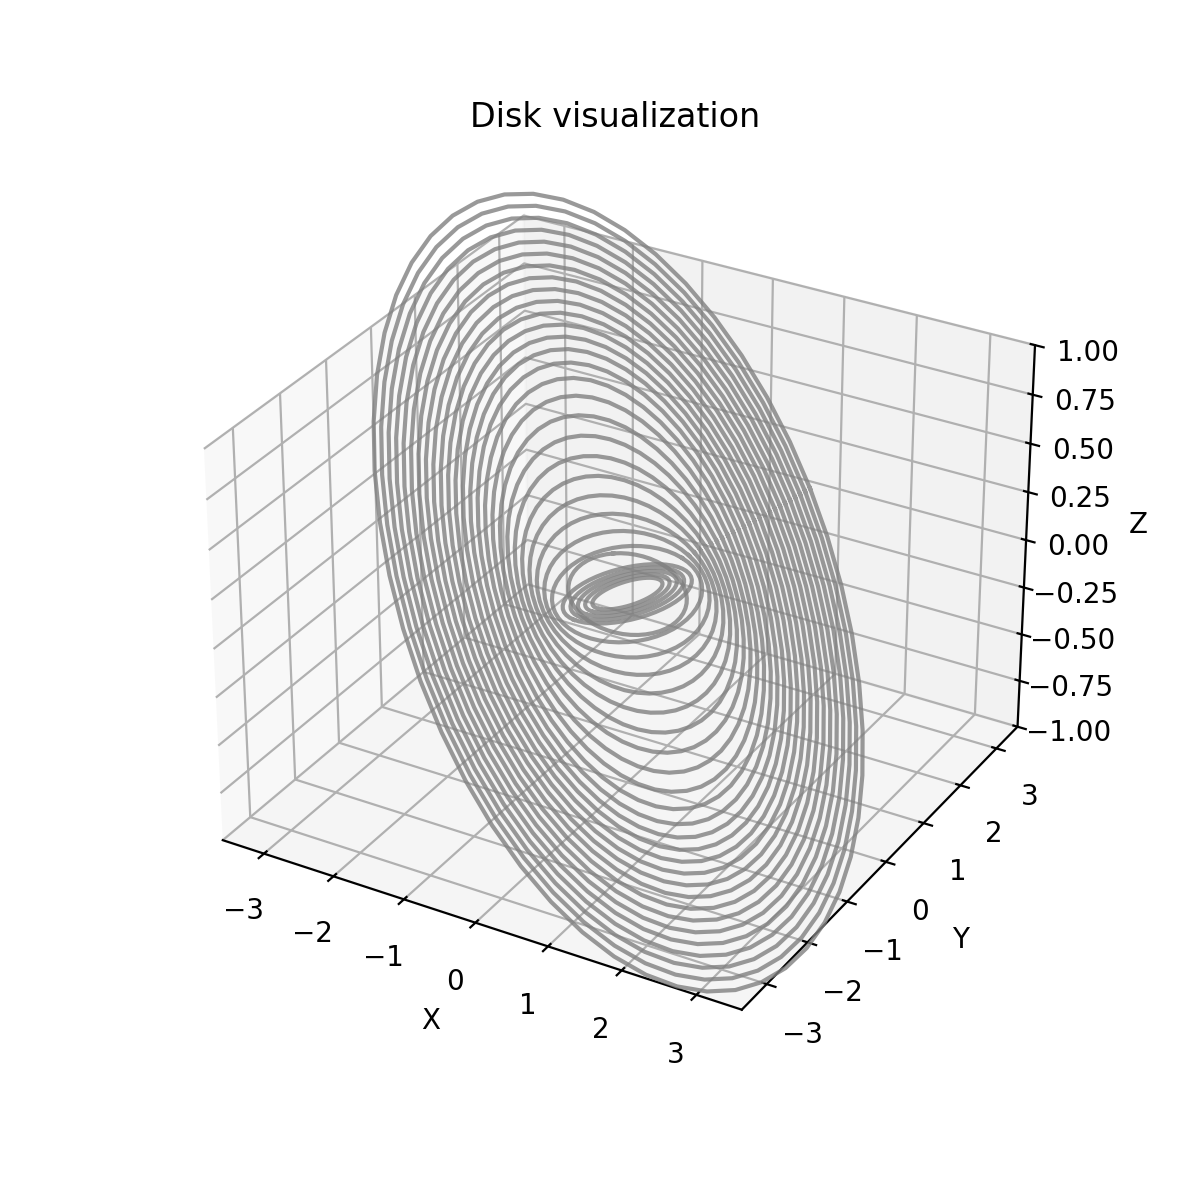

Elapsed time: 0.02


In [50]:
start = time.time()
plot_disk(Ws_final, Rs_warp)
end = time.time()
print("Elapsed time:", np.round(end - start, 2))

## Compare to steady-state solution

### plug into PDEs

<IPython.core.display.Javascript object>


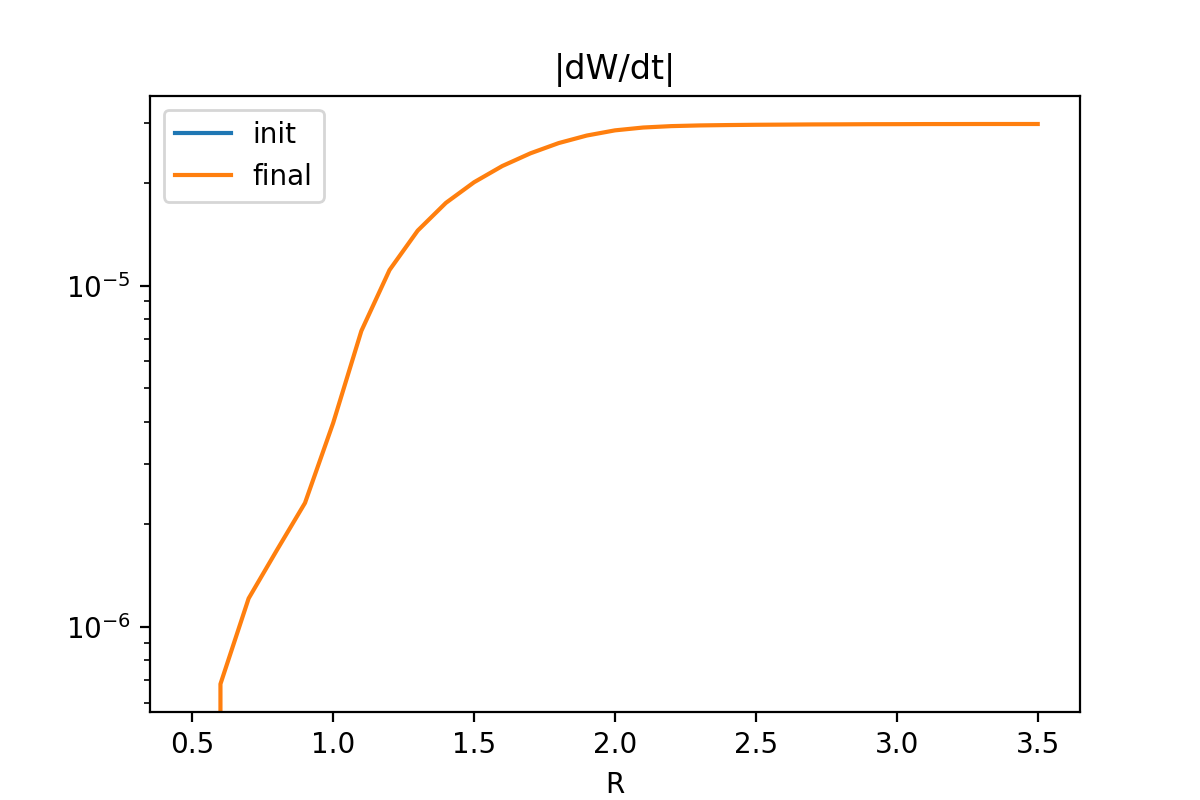

In [46]:
fig = plt.figure(figsize=(6,4))

dWdts_init = dW_dt(Rs_torque, Gs_init, Rs_warp, Ws_init, Mp, a, \
       use_ext_torque=True, inner_Neumann=use_innNeum, outer_Neumann=use_outNeum)

plt.plot(Rs_warp, np.abs(dWdts_init), label="init")

dWdts_final = dW_dt(Rs_torque, Gs_final, Rs_warp, Ws_final, Mp, a, \
        use_ext_torque=True, inner_Neumann=use_innNeum, outer_Neumann=use_outNeum)

plt.plot(Rs_warp, np.abs(dWdts_final), label="final")


plt.xlabel("R")
plt.yscale("log")
plt.title("|dW/dt|")

plt.legend()
plt.show()

<IPython.core.display.Javascript object>


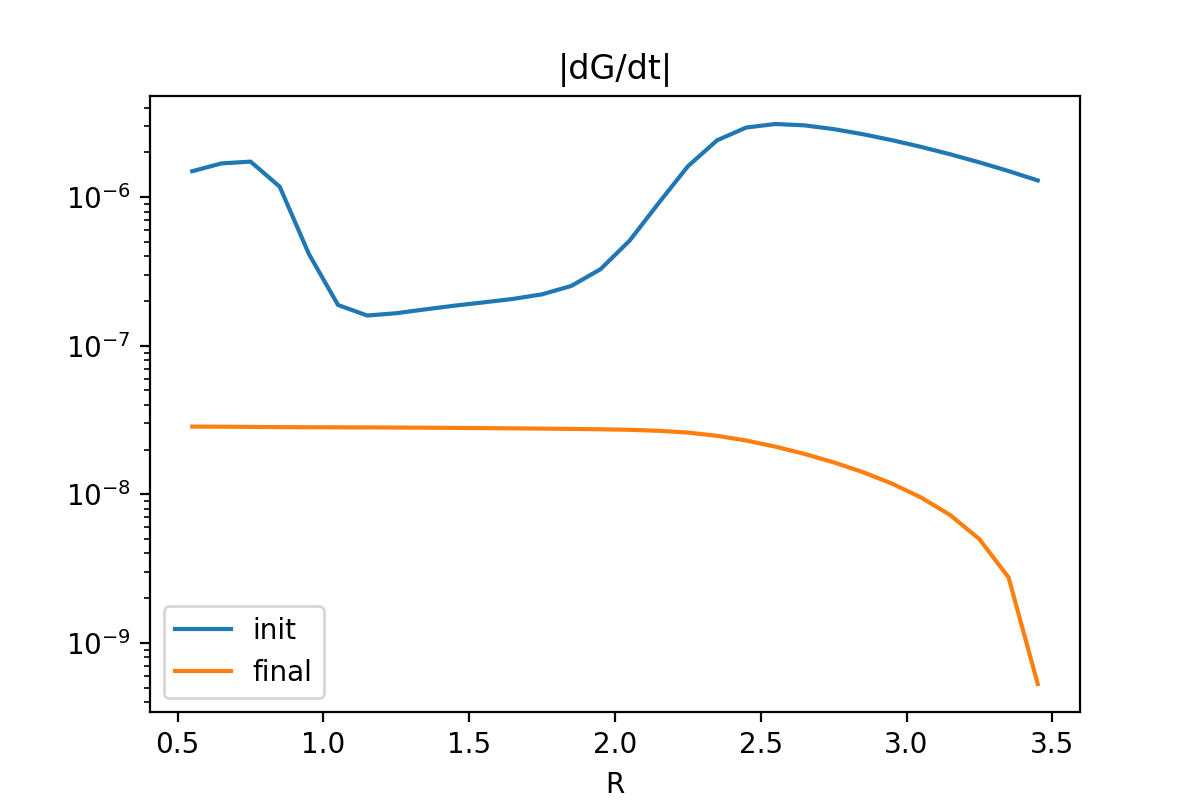

In [43]:
fig = plt.figure(figsize=(6,4))

dGdts_init = dG_dt(Rs_torque, Gs_init, Rs_warp, Ws_init, Mp, a, \
                    use_ext_torque=True)

plt.plot(Rs_torque, np.abs(dGdts_init), label="init")

dGdts_final = dG_dt(Rs_torque, Gs_final, Rs_warp, Ws_final, Mp, a,  \
                    use_ext_torque=True)

plt.plot(Rs_torque, np.abs(dGdts_final), label="final")


plt.xlabel("R")
plt.yscale("log")
plt.title("|dG/dt|")

plt.legend()
plt.show()

### compare to dW/dR

In [23]:
# check that, if Neumann conditions are on, W changes at boundaries
# print(Ws[0] - Ws_final[0])
# print(Ws[-1] - Ws_final[-1])

In [24]:
#Gs_final[-1]

In [25]:
#plt.plot(Gs_final)

In [26]:
def dW_dR_ss(Rs):
    '''
    Computes the steady-state value of dW_dR. Assumes no external torque, 
    so we can write G(R) = constant.
    
    '''
    
    return alpha * Omega(Rs_warp) * Gs_final[-1] / \
            (Sigma(Rs) * scaleHeight(Rs)**2 * Omega(Rs)**3 * Rs**3 / 4)


# fig = plt.figure()
# fig.set_facecolor("white")

# plt.plot(Rs_warp, np.gradient(Ws_final, Rs_warp), label="sim")
# # in steady-state, G should be constant
# plt.plot(Rs_warp, dW_dR_ss(Rs_warp), label="steady state")

# plt.scatter([],[], s=0, label="t=" + str(tmax))
# plt.scatter([],[], s=0, label="alpha=" + str(alpha))

# plt.title("dW/dR")
# plt.legend()